In [10]:
%matplotlib inline

import gym
import matplotlib
import numpy as np
import sys

from collections import defaultdict
if "../" not in sys.path:
    sys.path.append("../") 
from lib.envs.blackjack import BlackjackEnv
from lib import plotting
from lib.utils import randargmax

matplotlib.style.use('ggplot')

In [2]:
env = BlackjackEnv()

In [7]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        A = np.divide(np.ones(nA, dtype=np.float32)*epsilon, nA)
        opt_action = randargmax(Q[observation])
        # Account that optimal action can be selected randomly
        # cf. http://www0.cs.ucl.ac.uk/staff/d.silver/web/Teaching_files/control.pdf
        A[opt_action] += (1.0 - epsilon)
        return A
    return policy_fn

In [19]:
def mc_control_epsilon_greedy(env, num_episodes, discount_factor=1.0, epsilon=0.1):
    """
    Monte Carlo Control using Epsilon-Greedy policies.
    Finds an optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        discount_factor: Gamma discount factor.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities
    """
    
    def generate_episode(env, policy):
        episode = []
        state = env.reset()
        while True:
            probs = policy(state)
            action = np.random.choice(np.arange(len(probs)), p=probs)
            next_state, reward, done, _ = env.step(action)
            episode.append(state)
            episode.append(action)
            episode.append(reward)
            if done:
                break
            state = next_state
        return episode
    
    # Keeps track of sum and count of returns for each state
    # to calculate an average. We could use an array to save all
    # returns (like in the book) but that's memory inefficient.
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    # The final action-value function.
    # A nested dictionary that maps state -> action values (numpy array of size nA)
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    # Loop for each episode
    for e in range(1, num_episodes+1):
        if e % 1000 == 0:
            print("\rEpisode {}/{}.".format(e, num_episodes), end="")
            sys.stdout.flush()

        # generate an episode following policy
        episode = generate_episode(env, policy)
        state_action = set() # store unique state-action pairs
        # Loop for each step of episode
        for state_idx in range(0, len(episode), 3):
            state = episode[state_idx]
            action = episode[state_idx+1]
            sap = (state, action)
            # consider only first occurence of each state-action pair
            if sap not in state_action:
                state_action.add(sap)
                returns_count[sap] += 1
                # increment sum of returns
                returns_sum[sap] += sum([ discount_factor**i * episode[reward_idx] for i, reward_idx in enumerate(range(state_idx+2, len(episode), 3)) ])
                # update state-action value by averaging the returns of that state-action pair over all episodes
                Q[state][action] = returns_sum[sap] / returns_count[sap]
                policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
            
    
    return Q, policy

In [20]:
Q, policy = mc_control_epsilon_greedy(env, num_episodes=500000, epsilon=0.1)

Episode 500000/500000.

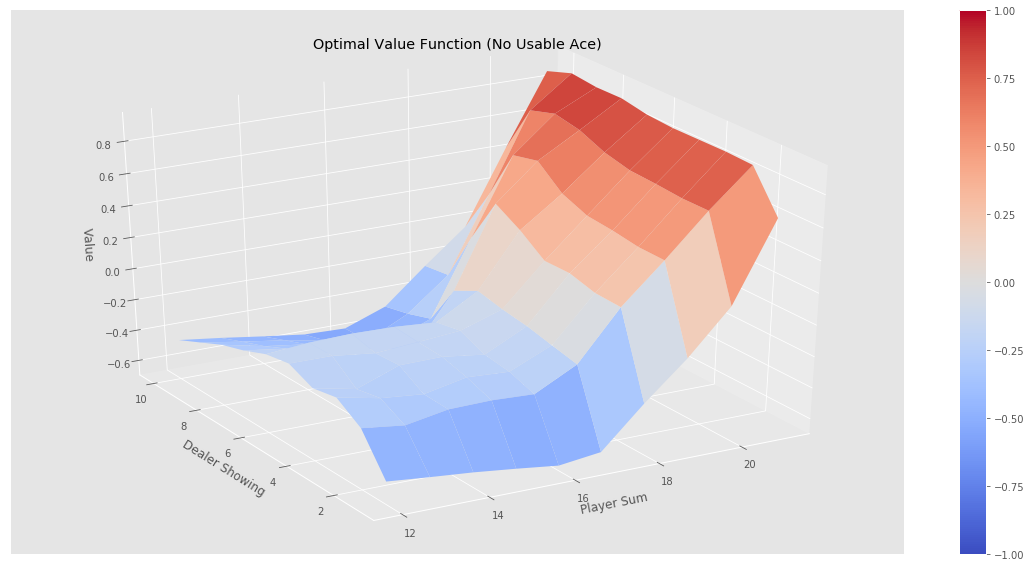

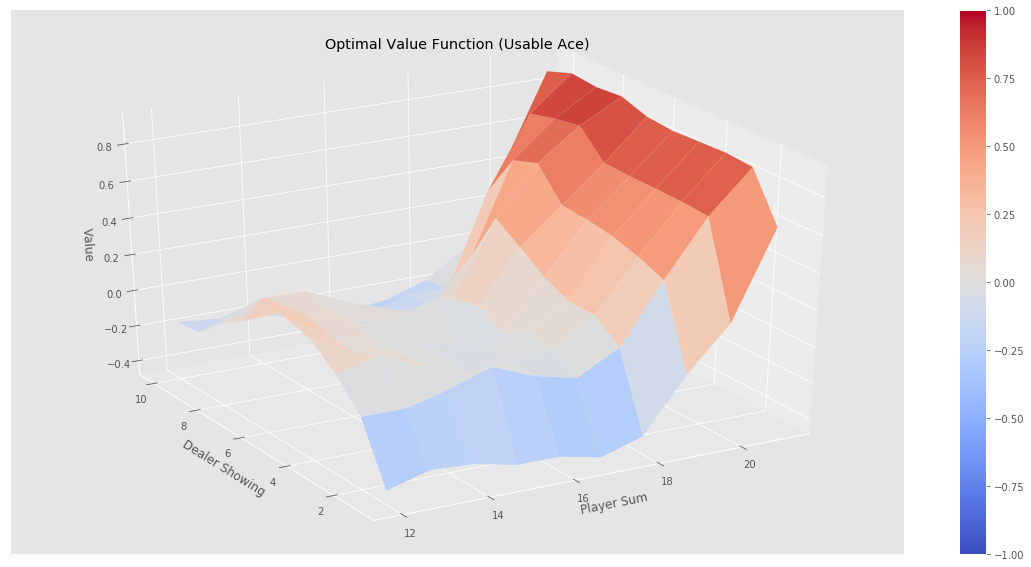

In [22]:
# For plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
for state, actions in Q.items():
    action_value = np.max(actions)
    V[state] = action_value
plotting.plot_value_function(V, title="Optimal Value Function")